# RT-DETR on OI-PBC (5-Class WBC Detection)


In [1]:
#pip install torchmetrics

Note: you may need to restart the kernel to use updated packages.


In [119]:
import sys
!{sys.executable} -m pip install git+https://github.com/jacobgil/pytorch-grad-cam.git


  Cloning https://github.com/jacobgil/pytorch-grad-cam.git to /tmp/pip-req-build-czjqh9pj
  Running command git clone --filter=blob:none --quiet https://github.com/jacobgil/pytorch-grad-cam.git /tmp/pip-req-build-czjqh9pj
  Resolved https://github.com/jacobgil/pytorch-grad-cam.git to commit 781dbc0d16ffa95b6d18b96b7b829840a82d93d1
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [121]:
from pytorch_grad_cam import GradCAM
print(GradCAM)


<class 'pytorch_grad_cam.grad_cam.GradCAM'>


In [61]:
import os, random, torch
from datasets import Dataset
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches


In [62]:
DATA_ROOT = "./data/Dataset/PBC-YOLO-721"
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

In [63]:
CLASS_NAMES = ["BA","BNE","EO","ERB","LY","MMY","MO","MY","PLT","PMY","RBC","SNE"]
WBC_MERGE_MAP = {"BA":"Basophil","EO":"Eosinophil","LY":"Lymphocyte","MO":"Monocyte","BNE":"Neutrophil","SNE":"Neutrophil"}
WBC_CLASSES = ["Neutrophil","Lymphocyte","Monocyte","Eosinophil","Basophil"]
NEW_NAME2ID = {n:i for i,n in enumerate(WBC_CLASSES)}
NEW_ID2LABEL = {i:n for n,i in NEW_NAME2ID.items()}

In [64]:
def build_split_fast(split):
    img_dir=os.path.join(DATA_ROOT,'images',split)
    lbl_dir=os.path.join(DATA_ROOT,'labels',split)
    rec=[]
    for f in os.listdir(img_dir):
        if f.lower().endswith(('.jpg','.png','.jpeg')):
            rec.append({'image_path':os.path.join(img_dir,f),'label_path':os.path.join(lbl_dir,f.rsplit('.',1)[0]+'.txt')})
    return Dataset.from_list(rec)
train_raw=build_split_fast('train')
val_raw=build_split_fast('val')

In [65]:
def filter_to_wbc_fast(ds):
    out=[]
    for s in ds:
        if not os.path.exists(s['label_path']): continue
        with open(s['label_path']) as f:
            for line in f:
                parts=line.strip().split()[-5:]
                try: cid=int(float(parts[0]))
                except: continue
                if CLASS_NAMES[cid] in WBC_MERGE_MAP:
                    out.append(s); break
    return Dataset.from_list(out)
train_raw=filter_to_wbc_fast(train_raw)
val_raw=filter_to_wbc_fast(val_raw)

In [66]:
def load_yolo_labels(lbl,w,h):
    anns=[]
    if not os.path.exists(lbl): return anns
    with open(lbl) as f:
        for line in f:
            parts=line.strip().split()[-5:]
            try: cls,xc,yc,bw,bh=map(float,parts)
            except: continue
            bw*=w; bh*=h
            x=xc*w-bw/2; y=yc*h-bh/2
            anns.append({'bbox':[x,y,bw,bh],'category_id':int(cls),'area':bw*bh,'iscrowd':0})
    return anns

In [104]:
def load_raw_sample(ds):
    s=random.choice(ds)
    img=Image.open(s['image_path']).convert('RGB')
    w,h=img.size
    raw=load_yolo_labels(s['label_path'],w,h)
    anns=[]
    for a in raw:
        n=CLASS_NAMES[a['category_id']]
        if n in WBC_MERGE_MAP:
            a=a.copy(); a['category_id']=NEW_NAME2ID[WBC_MERGE_MAP[n]]
            anns.append(a)
    return {'image':img,'annotations':anns}

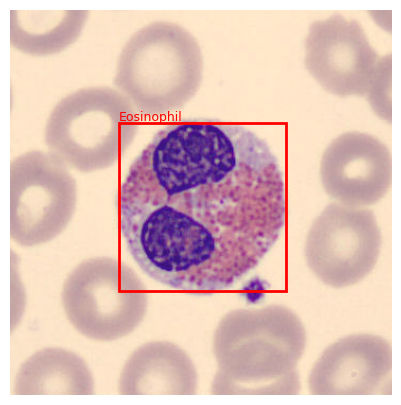

In [105]:
sample = load_raw_sample(train_raw)
visualize_gt(sample, NEW_ID2LABEL)


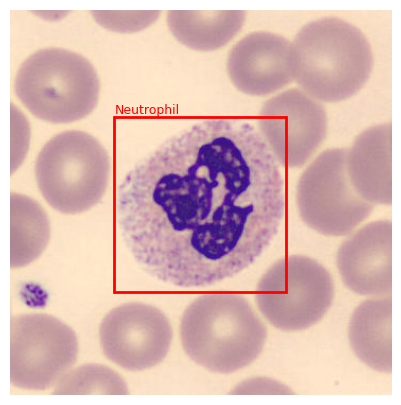

In [106]:
def visualize_gt(sample,id2label):
    fig,ax=plt.subplots(1,figsize=(5,5))
    ax.imshow(sample['image']); ax.axis('off')
    for a in sample['annotations']:
        x,y,w,h=a['bbox']
        ax.add_patch(patches.Rectangle((x,y),w,h,edgecolor='r',facecolor='none',lw=2))
        ax.text(x,y-2,id2label[a['category_id']],color='r',fontsize=9)
    plt.show()
    
visualize_gt(load_raw_sample(train_raw),NEW_ID2LABEL)

In [19]:
from transformers import RTDetrImageProcessor,RTDetrForObjectDetection,Trainer,TrainingArguments
processor=RTDetrImageProcessor.from_pretrained('PekingU/rtdetr_r50vd',format='coco_detection')

In [20]:
def transform(batch):
    images=[]; coco=[]
    for i,(ip,lp) in enumerate(zip(batch['image_path'],batch['label_path'])):
        img=Image.open(ip).convert('RGB'); w,h=img.size
        raw=load_yolo_labels(lp,w,h)
        anns=[]
        for a in raw:
            n=CLASS_NAMES[a['category_id']]
            if n in WBC_MERGE_MAP:
                a=a.copy(); a['category_id']=NEW_NAME2ID[WBC_MERGE_MAP[n]]
                anns.append(a)
        images.append(img); coco.append({'image_id':i,'annotations':anns})
    return processor(images=images,annotations=coco,return_tensors='pt')
train_ds=train_raw; val_ds=val_raw
train_ds.set_transform(transform); val_ds.set_transform(transform)

In [21]:
model=RTDetrForObjectDetection.from_pretrained(
    'PekingU/rtdetr_r50vd',
    num_labels=len(WBC_CLASSES),
    id2label=NEW_ID2LABEL,
    label2id=NEW_NAME2ID,
    ignore_mismatched_sizes=True
).to(DEVICE)

Loading weights:   0%|          | 0/764 [00:00<?, ?it/s]

RTDetrForObjectDetection LOAD REPORT from: PekingU/rtdetr_r50vd
Key                                                 | Status   |                                                                                      
----------------------------------------------------+----------+--------------------------------------------------------------------------------------
model.decoder.class_embed.{0, 1, 2, 3, 4, 5}.bias   | MISMATCH | Reinit due to size mismatch ckpt: torch.Size([80]) vs model:torch.Size([5])          
model.decoder.class_embed.{0, 1, 2, 3, 4, 5}.weight | MISMATCH | Reinit due to size mismatch ckpt: torch.Size([80, 256]) vs model:torch.Size([5, 256])
model.denoising_class_embed.weight                  | MISMATCH | Reinit due to size mismatch ckpt: torch.Size([81, 256]) vs model:torch.Size([6, 256])
model.enc_score_head.bias                           | MISMATCH | Reinit due to size mismatch ckpt: torch.Size([80]) vs model:torch.Size([5])          
model.enc_score_head.weight   

In [22]:
args = TrainingArguments(
    output_dir='./rtdetr_wbc5',
    per_device_train_batch_size=4,
    num_train_epochs=2,
    remove_unused_columns=False,
    fp16=torch.cuda.is_available(),
    report_to=[]
)

In [23]:
def collate_fn(batch):
    return {
        "pixel_values": torch.stack([x["pixel_values"] for x in batch]),
        "pixel_mask": torch.stack([x["pixel_mask"] for x in batch])
            if "pixel_mask" in batch[0] else None,
        "labels": [x["labels"] for x in batch],  # DO NOT stack
    }


In [24]:
trainer = Trainer(
    model=model,
    args=args,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    data_collator=collate_fn,   # 🔴 THIS IS REQUIRED
)


In [25]:
trainer.train()

Step,Training Loss
500,36.561555
1000,9.805026
1500,8.601395
2000,8.012343
2500,7.924313
3000,7.634615


TrainOutput(global_step=3366, training_loss=12.48931953670436, metrics={'train_runtime': 1161.6003, 'train_samples_per_second': 11.589, 'train_steps_per_second': 2.898, 'total_flos': 4.2416318655184896e+18, 'train_loss': 12.48931953670436, 'epoch': 2.0})

### Interpret Training Losses

In [26]:
trainer.state.log_history[-5:]


[{'loss': 8.60139453125,
  'grad_norm': 202.0072479248047,
  'learning_rate': 2.773321449792038e-05,
  'epoch': 0.8912655971479501,
  'step': 1500},
 {'loss': 8.0123427734375,
  'grad_norm': 24.333332061767578,
  'learning_rate': 2.030600118835413e-05,
  'epoch': 1.1883541295306002,
  'step': 2000},
 {'loss': 7.9243125,
  'grad_norm': 78.27487182617188,
  'learning_rate': 1.287878787878788e-05,
  'epoch': 1.4854426619132501,
  'step': 2500},
 {'loss': 7.63461474609375,
  'grad_norm': 23.245450973510742,
  'learning_rate': 5.451574569221629e-06,
  'epoch': 1.7825311942959001,
  'step': 3000},
 {'train_runtime': 1161.6003,
  'train_samples_per_second': 11.589,
  'train_steps_per_second': 2.898,
  'total_flos': 4.2416318655184896e+18,
  'train_loss': 12.48931953670436,
  'epoch': 2.0,
  'step': 3366}]

### COCO mAP / AP50 Evaluation

In [27]:
from torchmetrics.detection.mean_ap import MeanAveragePrecision

metric = MeanAveragePrecision(box_format="xyxy", iou_type="bbox")


In [28]:
@torch.no_grad()
def evaluate_map(model, dataloader, device):
    model.eval()
    metric.reset()

    for batch in dataloader:
        pixel_values = batch["pixel_values"].to(device)
        pixel_mask = batch.get("pixel_mask")
        if pixel_mask is not None:
            pixel_mask = pixel_mask.to(device)

        outputs = model(pixel_values=pixel_values, pixel_mask=pixel_mask)

        preds, targets = [], []

        for i in range(len(batch["labels"])):
            logits = outputs.logits[i]
            boxes = outputs.pred_boxes[i]

            scores = logits.softmax(-1)
            conf, labels = scores.max(-1)

            keep = conf > 0.3
            boxes = boxes[keep]
            labels = labels[keep]
            conf = conf[keep]

            preds.append({
                "boxes": boxes,
                "scores": conf,
                "labels": labels
            })

            targets.append({
                "boxes": batch["labels"][i]["boxes"].to(device),
                "labels": batch["labels"][i]["class_labels"].to(device)
            })

        metric.update(preds, targets)

    return metric.compute()


In [29]:
val_loader = trainer.get_eval_dataloader()
map_results = evaluate_map(model, val_loader, DEVICE)

print("mAP:", map_results["map"].item())
print("AP50:", map_results["map_50"].item())


/home/akash/jupyter_projects/jupyter_env/lib/python3.12/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: Encountered more than 100 detections in a single image. This means that certain detections with the lowest scores will be ignored, that may have an undesirable impact on performance. Please consider adjusting the `max_detection_threshold` to suit your use case. To disable this warning, set attribute class `warn_on_many_detections=False`, after initializing the metric.
  warnings.warn(*args, **kwargs)


mAP: 0.0009233295568265021
AP50: 0.002765270648524165


### Visualize Predictions vs Ground Truth

In [128]:
from torchvision.ops import nms

def cxcywh_to_xyxy(boxes, w, h):
    cx, cy, bw, bh = boxes.unbind(-1)
    x1 = (cx - bw / 2) * w
    y1 = (cy - bh / 2) * h
    x2 = (cx + bw / 2) * w
    y2 = (cy + bh / 2) * h
    return torch.stack([x1, y1, x2, y2], dim=-1)


def visualize_predictions(
    model,
    dataset,
    processor,
    id2label,
    device,
    score_thr=0.6,   # stronger threshold
    top_k=20
):
    model.eval()
    sample = random.choice(dataset)

    img = Image.open(sample["image_path"]).convert("RGB")
    w, h = img.size

    inputs = processor(images=img, return_tensors="pt").to(device)

    outputs = model(**inputs)

    logits = outputs.logits[0]
    boxes = outputs.pred_boxes[0]

    # ── 1️⃣ confidence filtering (THRESHOLDING)
    scores = logits.softmax(-1)
    conf, labels = scores.max(-1)

    keep = conf > score_thr
    boxes = boxes[keep]
    labels = labels[keep]
    conf = conf[keep]

    if len(conf) == 0:
        print("No detections above threshold")
        return

    # ── 2️⃣ top-K filtering (THIS IS WHAT I MEANT)
    if len(conf) > top_k:
        topk = torch.topk(conf, top_k)
        idx = topk.indices
        boxes = boxes[idx]
        labels = labels[idx]
        conf = conf[idx]

    # ── 3️⃣ NMS (REQUIRED FOR RT-DETR)
    xyxy = cxcywh_to_xyxy(boxes, w, h)
    nms_idx = nms(xyxy, conf, iou_threshold=0.4)

    xyxy = xyxy[nms_idx]
    labels = labels[nms_idx]
    conf = conf[nms_idx]

    # ── 4️⃣ Visualization
    fig, ax = plt.subplots(1, figsize=(6, 6))
    ax.imshow(img)
    ax.axis("off")

    for box, lab, sc in zip(xyxy, labels, conf):
        x1, y1, x2, y2 = box.detach().cpu().numpy()

        ax.add_patch(
            patches.Rectangle(
                (x1, y1),
                x2 - x1,
                y2 - y1,
                edgecolor="lime",
                facecolor="none",
                lw=2
            )
        )
        ax.text(
            x1,
            y1 - 2,
            f"{id2label[lab.item()]} {sc:.2f}",
            color="lime",
            fontsize=9,
            backgroundcolor="black"
        )

    plt.show()


In [129]:
train_raw_vis = build_split_fast("train")
train_raw_vis = filter_to_wbc_fast(train_raw_vis)


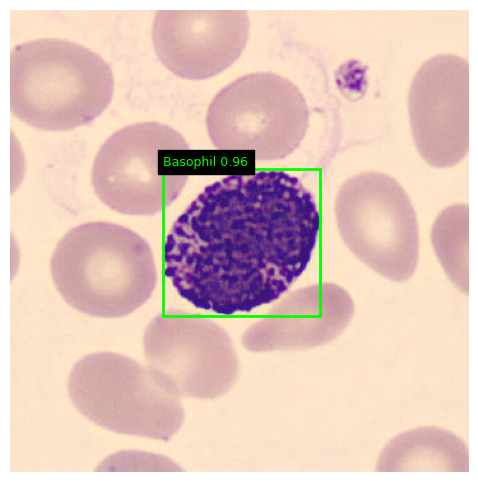

In [130]:
visualize_predictions(model, train_raw_vis, processor, NEW_ID2LABEL, DEVICE)


### Grad-CAM & Score-CAM

In [132]:
!python -m pip show grad-cam


Name: grad-cam
Version: 1.5.5
Summary: Many Class Activation Map methods implemented in Pytorch for classification, segmentation, object detection and more
Home-page: https://github.com/jacobgil/pytorch-grad-cam
Author: Jacob Gildenblat
Author-email: jacob.gildenblat@gmail.com
License: 
Location: /home/akash/jupyter_projects/jupyter_env/lib/python3.12/site-packages
Requires: matplotlib, numpy, opencv-python, Pillow, scikit-learn, torch, torchvision, tqdm, ttach
Required-by: 


In [133]:
import torch
import numpy as np
import cv2
from pytorch_grad_cam import GradCAM, ScoreCAM
from pytorch_grad_cam.utils.image import show_cam_on_image


In [134]:
print(model.model.backbone)

RTDetrConvEncoder(
  (model): RTDetrResNetBackbone(
    (embedder): RTDetrResNetEmbeddings(
      (embedder): Sequential(
        (0): RTDetrResNetConvLayer(
          (convolution): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
          (normalization): RTDetrFrozenBatchNorm2d()
          (activation): ReLU()
        )
        (1): RTDetrResNetConvLayer(
          (convolution): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (normalization): RTDetrFrozenBatchNorm2d()
          (activation): ReLU()
        )
        (2): RTDetrResNetConvLayer(
          (convolution): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (normalization): RTDetrFrozenBatchNorm2d()
          (activation): ReLU()
        )
      )
      (pooler): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    )
    (encoder): RTDetrResNetEncoder(
      (stages): ModuleList(
        (0)

In [135]:
# Target layer (correct for RT-DETR ResNet backbone)
target_layer = (
    model.model.backbone.model.encoder.stages[-1]
    .layers[-1]
    .layer[-1]
)

cam = GradCAM(
    model=model,
    target_layers=[target_layer]
)



In [136]:
print(target_layer)


RTDetrResNetConvLayer(
  (convolution): Conv2d(512, 2048, kernel_size=(1, 1), stride=(1, 1), bias=False)
  (normalization): RTDetrFrozenBatchNorm2d()
  (activation): Identity()
)


In [137]:
class RTDETRTarget_old:
    def __init__(self, class_idx=None):
        self.class_idx = class_idx

    def __call__(self, outputs):
        # outputs.logits: [num_queries, num_classes]
        scores = outputs.logits.softmax(-1)

        if self.class_idx is None:
            return scores.max()
        else:
            return scores[:, self.class_idx].max()


In [138]:
class RTDETRTarget:
    def __init__(self, class_idx=None):
        self.class_idx = class_idx

    def __call__(self, outputs):
        # outputs is a DICT, not an object
        logits = outputs["logits"]          # shape: [B, Q, C]
        scores = logits.softmax(-1)

        if self.class_idx is None:
            return scores.max()

        return scores[..., self.class_idx].max()


In [139]:
def preprocess_image(img, processor, device):
    inputs = processor(images=img, return_tensors="pt")
    return inputs["pixel_values"].to(device)


In [146]:
def run_gradcam(model, processor, img, target_class=None):
        
    DEVICE = "cpu"
    model = model.to("cpu")
    pixel_values = pixel_values.to("cpu")

    # freeze everything except backbone
    for p in model.parameters():
        p.requires_grad = False

    for p in model.backbone.parameters():
        p.requires_grad = True

    img = img.resize((512, 512))

    target_layer = model.backbone.body.layer4[-1]
    
    cam = GradCAM(
    model=model,
    target_layers=[target_layer]
    )

    outputs = model(pixel_values=pixel_values)

    targets = None
    if target_class is not None:
        targets = [RTDETRTarget(target_class)]
        
    grayscale_cam = cam(
        input_tensor=pixel_values,
        targets=targets
    )
    grayscale_cam = grayscale_cam[0]

    return grayscale_cam


In [141]:
def run_scorecam(model, processor, img, target_class=None):
    model.eval()

    pixel_values = preprocess_image(img, processor, DEVICE)

    cam = ScoreCAM(
        model=model,
        target_layers=[target_layer]
    )

    outputs = model(pixel_values=pixel_values)

    targets = [RTDETRTarget(target_class)]
    grayscale_cam = cam(
        input_tensor=pixel_values,
        targets=targets
    )[0]

    img_np = np.array(img).astype(np.float32) / 255.0
    cam_img = show_cam_on_image(img_np, grayscale_cam, use_rgb=True)

    return cam_img


In [142]:
print(train_raw[0].keys())


dict_keys(['image_path', 'label_path'])


In [147]:

torch.cuda.empty_cache()


In [148]:
cam_grad = run_gradcam(model, processor, img)
plt.imshow(cam_grad)
plt.axis("off")


UnboundLocalError: cannot access local variable 'pixel_values' where it is not associated with a value

In [149]:
cam_grad = run_gradcam(model, processor, img)
plt.imshow(cam_grad)
plt.axis("off")


UnboundLocalError: cannot access local variable 'pixel_values' where it is not associated with a value

In [ ]:
cam_score = run_scorecam(model, processor, img)
plt.imshow(cam_score)
plt.axis("off")
